In [79]:
%matplotlib notebook
import numpy as np
import pandas as pd


In [80]:
data_train=pd.read_csv('input/train.csv')
data_test=pd.read_csv('input/test.csv')

In [81]:
data_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [82]:
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Data Visualization

In [83]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set() # setting seaborn default for plots

In [84]:
def bar(data):
    x=['Survived','Dead']
    col=['Pclass','Sex','SibSp','Parch','Embarked']
    for i in range(len(col)):
        survived=data[data['Survived']==1][col[i]].value_counts().sort_index()
        dead=data[data['Survived']==0][col[i]].value_counts().sort_index()
        bar=pd.DataFrame([survived,dead])
        bar.index=(['Survived','Dead'])
        bar.plot(kind='bar',stacked=True,title=col[i])

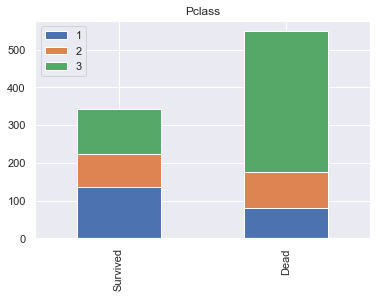

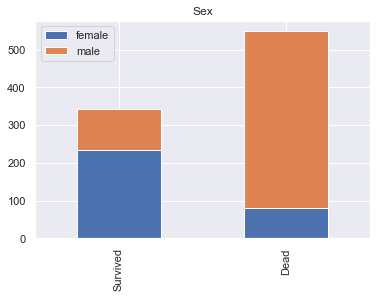

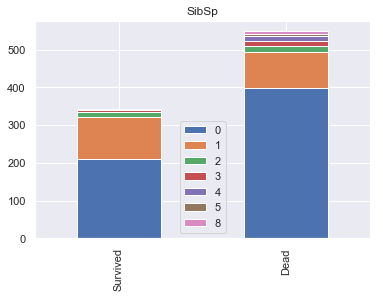

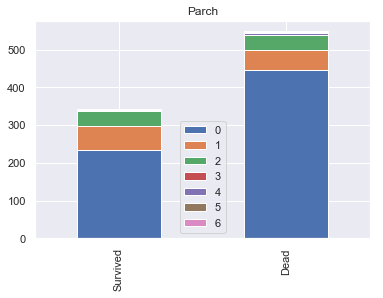

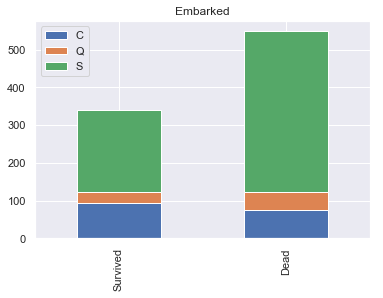

In [85]:
bar(data_train)

In [86]:
label=data_train['Survived']
data_train=data_train.drop('Survived', axis=1)

### Feature Engineering
We are going to vectorlize the features in the data so that we can apply machine learning model to predict 
There are some functions below. With each function, I am going to vectorlize one feature in this data


### 1)Name
We got some infomation in the fearture 'Name' such as : "Mr", "Mrs", "Miss". This infomation gives us that whether or not the person got married

In [87]:
def name(train):
    train['Name']=train['Name'].str.extract(' ([A-Za-z]+)\.', expand=False) # Extract all name, ater this step, we have "Mr",.. instead the whole name
    title=pd.DataFrame(train['Name'].value_counts())
    title['title']=title.index.map({"Mr":0,"Miss":1,"Mrs":2}) #Map the data into numerical value
    title['title']=title['title'].fillna(3) # Fill the missing data by median
    title['title']=title=title.drop('Name',axis=1)
    title_mapping=pd.Series(title['title'],title.index).to_dict()
    train['Name']=train['Name'].map(title_mapping) #Mapping

### 2) Sex
Map the data to numerical data

In [88]:
def sex(train):
    train['Sex']=train['Sex'].map({'male':1,'female':0})

### 3) Age
Map each range of the age to [0,1,2,3,4]

In [89]:
def age(train):
    train['Age'].fillna(train.groupby('Name')['Age'].transform("median"),inplace=True)# fill the missing data 
    condition=[(train['Age']<=16) ,
           (train['Age']>16)&(train['Age']<=26),
           (train['Age']>26)&(train['Age']<36),
           (train['Age']>36)&(train['Age']<=62),
           train['Age']>63]
    choice=[0,1,2,3,4]
    train['Age']=np.select(condition,choice)


### 4) Embarked
Fill the missing data by the most common value in this data ('S')

In [90]:
def embarked(train):
    embarked=train['Embarked'].value_counts()
    train['Embarked']=train['Embarked'].fillna(embarked.index[0])
    train['Embarked']=train['Embarked'].map({"S":0,"C":1,"Q":2})


### 5) Fare
Similarly, map the value

In [91]:
def fare(train):
    train['Fare'].fillna(train.groupby('Pclass')['Fare'].transform("median"),inplace=True)
    condition_fare=[(train['Fare']<=17),
               (train['Fare']>17) &(train['Fare']<=30),
               (train['Fare']>30) &(train['Fare']<=100),
               (train['Fare']>100)]
    choice_fare=[0,1,2,3]
    train['Fare']=np.select(condition_fare,choice_fare)


### 6) Cabin
The only thing need to take care is we choose the resonable numerical value to map. Because I already mapped previous fearture from 0 to 3 or 4, so in this feature, i also choose range [0,1,2,3] to map (feature scalling)

In [ ]:
def cabin(train):
    train['Cabin']=train['Cabin'].str[:1]
    cabin_mapping={"A":0,"B":0.4,"C":0.8,"D":1.2,"E":1.6,"F":2,"G":2.4,"T":2.8}
    train['Cabin']=train['Cabin'].map(cabin_mapping)
    train['Cabin'].fillna(train.groupby('Pclass')['Cabin'].transform('median'), inplace=True)


### 7) Familysize
I sum the 'SibSp' and 'Parch' and 1 to get the number of family person 

In [93]:
def familySize(train):
    train['FamilySize']=train['SibSp']+train['Parch']+1
    train['FamilySize']=train['FamilySize'].map( {1: 0, 2: 0.4, 3: 0.8, 4: 1.2, 5: 1.6, 
                                              6: 2, 7: 2.4, 8: 2.8, 9: 3.2, 10: 3.6, 11: 4})


### Call all the previous functions

In [94]:
def fearture_enginerring(train):
    name(train)
    sex(train)
    age(train)
    embarked(train)
    fare(train)
    cabin(train)
    familySize(train)
    train=train.drop(['Ticket','SibSp','Parch'], axis=1)
    return train
train=fearture_enginerring(data_train).drop('PassengerId', axis=1)

In [95]:
test=fearture_enginerring(data_test).drop('PassengerId', axis=1)

### Model
I try to apply 5 machine learning models in this data. After that, we can see SMV model give us the best result

In [97]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [98]:
k_fold=KFold(n_splits=10,shuffle=True, random_state=0)

#### KNN

In [99]:
from sklearn.neighbors import KNeighborsClassifier
clf=KNeighborsClassifier(n_neighbors=13)
score=cross_val_score(clf, train1, label, cv=k_fold, n_jobs=1, scoring='accuracy')
print(np.mean(score)*100,2)

82.379525593 2


#### Decision Tree

In [100]:
from sklearn.tree import DecisionTreeClassifier
clf=DecisionTreeClassifier()
score=cross_val_score(clf, train1, label, cv=k_fold, n_jobs=1, scoring='accuracy')
print(np.mean(score)*100,2)

79.6878901373 2


#### Random Forest

In [101]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier()
score=cross_val_score(clf, train1, label, cv=k_fold, n_jobs=1, scoring='accuracy')
print(np.mean(score)*100,2)

81.7066167291 2


C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: Future

#### Naive Bayes

In [102]:
from sklearn.naive_bayes import GaussianNB
clf= GaussianNB()
score=cross_val_score(clf, train1, label, cv=k_fold, n_jobs=1, scoring='accuracy')
print(np.mean(score)*100,2)

78.8926342072 2


#### SMV

In [103]:
from sklearn.svm import SVC
clf=SVC()
score=cross_val_score(clf, train1, label, cv=k_fold, n_jobs=1, scoring='accuracy')
print(np.mean(score)*100,2)

83.7253433208 2


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: 

### Testing
Predict the data using SMV model and submit the file

In [106]:
clf=SVC()
clf.fit(train, label)
prediction=clf.predict(test)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [109]:
file=pd.DataFrame({'PassengerId': data_test['PassengerId'],
                  'Survived': prediction})

In [113]:
file.to_csv('submit_kaggle.csv', index=False)